In [1]:
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import minigrid
from minigrid.wrappers import FlatObsWrapper, RGBImgObsWrapper
from minigrid.core.constants import IDX_TO_OBJECT, IDX_TO_COLOR
import matplotlib.pyplot as plt
import numpy as np

from scripts.agents import QLearningAgent, SARSAAgent
from scripts.training import Trainer, trainingInspector
from scripts.tilecoding import QTable

### Top 3 hyperparameters for Q-Learning and SARSA

In [2]:
# Top 3 hyperparameters for Q-Learning and SARSA
qlearning_hyperparameter_list = [
    
    # Best performing hyperparameters
    {
        "num_episodes": 1000,
        "max_return": 1,
        "num_tiles_per_feature": [4,9,2],
        "num_tilings": 1,
        "learning_rate": 0.1,
        "tau_start": 1000,
        "tau_end": 0.1,
        "decay_type": "exponential",
        "frac_episodes_to_decay": 0.1
    }
    # Second best performing hyperparameters
    # {
    #     "num_episodes": 10000,
    #     "max_return": -100,
    #     "num_tiles_per_feature": 20,
    #     "num_tilings": 1,
    #     "learning_rate": 0.1,
    #     "tau_start": 100000,
    #     "tau_end": 0.1,
    #     "decay_type": "exponential",
    #     "frac_episodes_to_decay": 0.1
    # }
    # Third best performing hyperparameters
    # {
    #     "num_episodes": 10000,
    #     "max_return": -100,
    #     "num_tiles_per_feature": 20,
    #     "num_tilings": 1,
    #     "learning_rate": 0.1,
    #     "tau_start": 100000,
    #     "tau_end": 0.1,
    #     "decay_type": "exponential",
    #     "frac_episodes_to_decay": 0.1
    # }
    
]

sarsa_hyperparameter_list = [
    
    # Best performing hyperparameters
    {
        "num_episodes": 1000,
        "max_return": 1,
        "num_tiles_per_feature": [4,9,2],
        "num_tilings": 1,
        "learning_rate": 0.1,
        "eps_start": 1,
        "eps_end": 0.01,
        "decay_type": "linear",
        "frac_episodes_to_decay": 0.1
    }
    # Second best performing hyperparameters
    # {
    #     "num_episodes": 10000,
    #     "max_return": -100,
    #     "num_tiles_per_feature": 20,
    #     "num_tilings": 4,
    #     "learning_rate": 0.1,
    #     "eps_start": 1,
    #     "eps_end": 0.01,
    #     "decay_type": "exponential",
    #     "frac_episodes_to_decay": 0.5
    # }
    # Third best performing hyperparameters
    # {
    #     "num_episodes": 10000,
    #     "max_return": -100,
    #     "num_tiles_per_feature": 20,
    #     "num_tilings": 4,
    #     "learning_rate": 0.1,
    #     "eps_start": 1,
    #     "eps_end": 0.01,
    #     "decay_type": "exponential",
    #     "frac_episodes_to_decay": 0.5
    # }
]


## Helper functions

In [3]:
def moving_average(arr, n=100):
    csum = np.cumsum(arr)
    csum[n:] = csum[n:] - csum[:-n]
    return csum[n - 1:] / n

def episode_trigger(x):
    if x % 100 == 0:
        return True
    return False

def compute_decay(param_start, param_end, frac_episodes_to_decay, num_episodes, decay_type):
    if decay_type == 'linear':
        param_decay = (param_start-param_end) / (frac_episodes_to_decay*num_episodes)
    elif decay_type == 'exponential':
        param_decay = 10 ** (np.log10(param_end/param_start) /
                           (frac_episodes_to_decay*num_episodes))

    return param_decay

## Code for testing and plotting

In [4]:
def test_agent(env, agent, trainer, hyperparameter_list, num_experiments=5):
    """To test agents and compute metrics
    """

    test_results = []

    for test_num, test_hyperparameters in enumerate(hyperparameter_list):
        
        num_episodes = test_hyperparameters["num_episodes"]    
        max_return = test_hyperparameters["max_return"]
        num_tiles_per_feature = test_hyperparameters["num_tiles_per_feature"]
        num_tilings = test_hyperparameters["num_tilings"]
        learning_rate = test_hyperparameters["learning_rate"]
        decay_type = test_hyperparameters["decay_type"]
        frac_episodes_to_decay = test_hyperparameters["frac_episodes_to_decay"]

        hyperparameters = {
            "NUM_TILINGS": num_tilings,
            "GAMMA": 0.99,
            "LR": learning_rate,
            "decay_type": decay_type,
        }
        
        if isinstance(num_tiles_per_feature, list):
            hyperparameters.update({
                "NUM_TILES_PER_FEATURE": num_tiles_per_feature
            })
        else:
            hyperparameters.update({
                "NUM_TILES_PER_FEATURE": [num_tiles_per_feature]*env.observation_space.shape[0]
            })           

        if isinstance(agent, QLearningAgent):
            label = "Q-Learning"
            param_start = test_hyperparameters["tau_start"]
            param_end = test_hyperparameters["tau_end"]
            hyperparameters.update({
                "tau_start": param_start,
                "tau_end": param_end,
                "tau_decay": compute_decay(param_start, param_end, 
                                           frac_episodes_to_decay, 
                                           num_episodes, decay_type)
            })
            
        elif isinstance(agent, SARSAAgent):
            label = "SARSA"
            param_start = test_hyperparameters["eps_start"]
            param_end = test_hyperparameters["eps_end"]
            hyperparameters.update({
                "eps_start": param_start,
                "eps_end": param_end,
                "eps_decay": compute_decay(param_start, param_end, 
                                           frac_episodes_to_decay, 
                                           num_episodes, decay_type)
            })
        
        result_history = {
            "experiment": [],
            "scores": [],
            "moving_average_scores": []
        }
        
        for experiment in range(1, num_experiments+1):
            agent.update_hyperparameters(**hyperparameters)
        
            ti = trainingInspector(max_return)
            
            results = trainer.training(
                env, agent,
                n_episodes=num_episodes,
                process_training_info=ti.process_training_info)
        
            result_history["scores"].append(results["scores"])
            result_history["moving_average_scores"].append(moving_average(results["scores"]))
        
        result_history["scores"] = np.array(result_history["scores"])
        result_history["moving_average_scores"] = np.array(result_history["moving_average_scores"])
        
        metrics = {
            "label": label + f" hyperparams {test_num + 1}",
            "episodes": range(1, num_episodes+1),
            "rolling_episodes": range(1, result_history["moving_average_scores"].shape[1] + 1),
            "means": result_history["scores"].mean(axis=0),
            "std_dev": result_history["scores"].std(axis=0),
            "rolling_means": result_history["moving_average_scores"].mean(axis=0),
            "rolling_std_dev": result_history["moving_average_scores"].std(axis=0)
        }

        test_results.append(metrics)

    return test_results

def plot_test_results(test_results, experiments):

    plt.subplots(1, 2, figsize=(16, 4))
    plt.subplot(1,2,1)
    plt.grid()
    plt.title("Scores vs Episodes")
    plt.xlabel("Episodes")
    plt.ylabel("Scores")
    for i in experiments:
        label = test_results[i]["label"]
        episodes = test_results[i]["episodes"]
        means = test_results[i]["means"]
        std_dev = test_results[i]["std_dev"]

        plt.plot(episodes, means, linewidth = 0.2, label=label)
        plt.fill_between(episodes, means-std_dev, means+std_dev, alpha=0.6)
        
    plt.legend()

    plt.subplot(1,2,2)
    plt.grid()
    plt.title("Rolling means of scores vs Episodes")
    plt.xlabel("Episodes")
    plt.ylabel("Rolling means of scores")
    for i in experiments:
        label = test_results[i]["label"]
        rolling_episodes = test_results[i]["rolling_episodes"]
        rolling_means = test_results[i]["rolling_means"]
        rolling_std_dev = test_results[i]["rolling_std_dev"]

        plt.plot(rolling_episodes, rolling_means, linewidth = 1, label=label)
        plt.fill_between(rolling_episodes, rolling_means-rolling_std_dev, rolling_means+rolling_std_dev, alpha=0.4)

    plt.legend()
    plt.tight_layout()

## Running experiments

In [5]:
class MinigridObsWrapper(gym.Wrapper):

    def __init__(self, env):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(np.array([0, 0, 0]), np.array([3, 8, 1]))

    def reset(self, *, seed=None, options=None):
        obs, info = self.env.reset(seed=seed, options=options)
        return self.observation(obs), info

    def step(self, action):
        observation, reward, terminated, truncated, info = self.env.step(action)
        return self.observation(observation), reward, terminated, truncated, info

    def get_front(self, observation):
        return IDX_TO_OBJECT[observation["image"][3,5,0]]

    def is_wall(self, row, col, grid):
        if (IDX_TO_OBJECT[grid[row,col]] == "wall"):
            return 1
        else:
            return 0

    def get_agent_pos(self, observation):
        obs_grid = np.fliplr(observation["image"][:,:,0])
        num_right = self.is_wall(4,0,obs_grid) + self.is_wall(5,0,obs_grid)
        num_front = self.is_wall(3,1,obs_grid) + self.is_wall(3,2,obs_grid)

        dirn = observation["direction"]
        if dirn == 0:
            return [2-num_right, 2-num_front]
        if dirn == 1:
            return [num_front, 2-num_right]
        if dirn == 2:
            return [num_right, num_front]
        if dirn == 3:
            return [2-num_front, num_right]

    def observation(self, observation):
        
        agent_pos = self.get_agent_pos(observation)

        agent_direction = observation["direction"]
        agent_pos_encoding = 3*(agent_pos[0])+(agent_pos[1])
        agent_path_clear = (self.get_front(observation) in ["empty", "goal"])

        mod_observation = np.array([
            agent_direction, 
            agent_pos_encoding, 
            agent_path_clear
        ])
        
        return mod_observation

In [6]:
env = gym.make('MiniGrid-Dynamic-Obstacles-5x5-v0', render_mode="rgb_array")
env = RecordVideo(
    env,
    video_folder="backups/minigrid-qlearning-visualizations",
    name_prefix="eval",
    episode_trigger=episode_trigger
)

env = MinigridObsWrapper(env)

sarsa_agent = SARSAAgent(
    state_space=env.observation_space,
    action_space=env.action_space,
    seed=0
)


qlearning_agent = QLearningAgent(
    state_space=env.observation_space,
    action_space=env.action_space,
    seed=0
)

trainer = Trainer()
qlearning_results = test_agent(env, qlearning_agent, trainer, qlearning_hyperparameter_list, num_experiments=5)
sarsa_results = test_agent(env, sarsa_agent, trainer, sarsa_hyperparameter_list, num_experiments=5)

env.close()

/home/lalit/my_venvs/rl_env/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /home/lalit/acads/DA6400/Assignment1/DA6400_RL_PA1/backups/minigrid-qlearning-visualizations folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 156.54it/s, Mean Score=0.794]


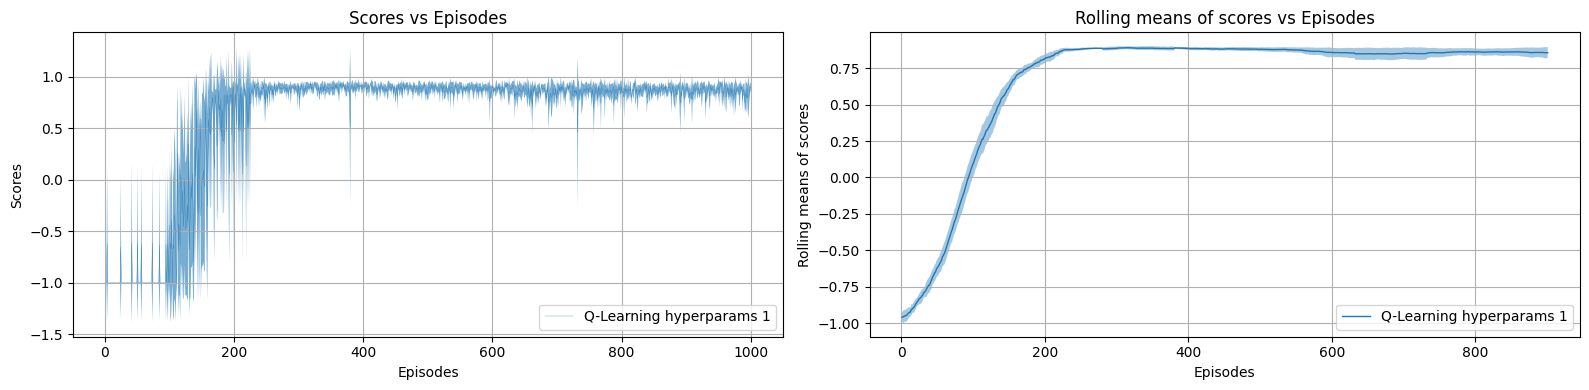

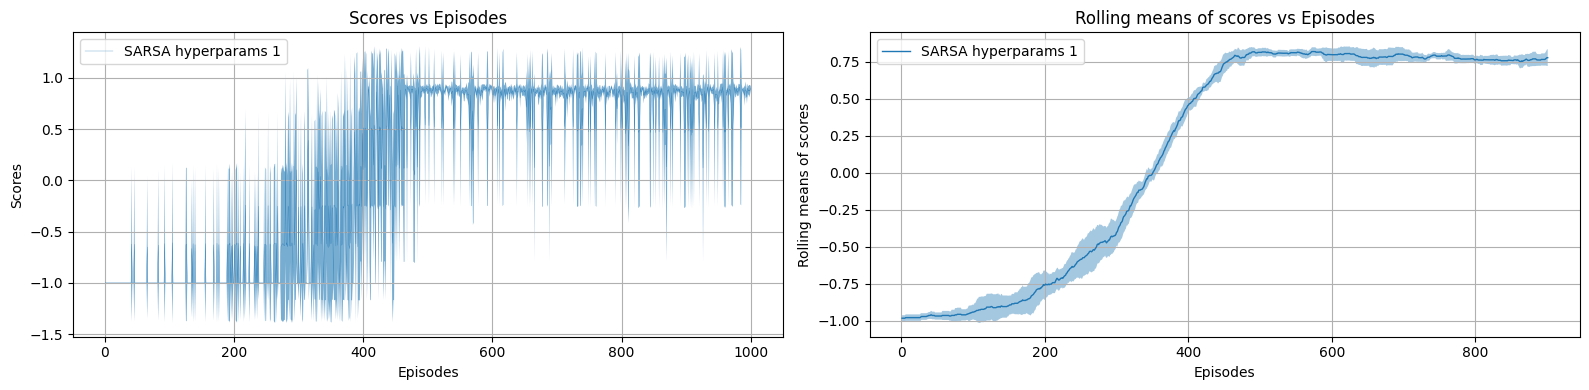

In [7]:
plot_test_results(qlearning_results, [0])
plot_test_results(sarsa_results, [0])

[0. 0. 0.] [0.00282742 0.         0.        ]


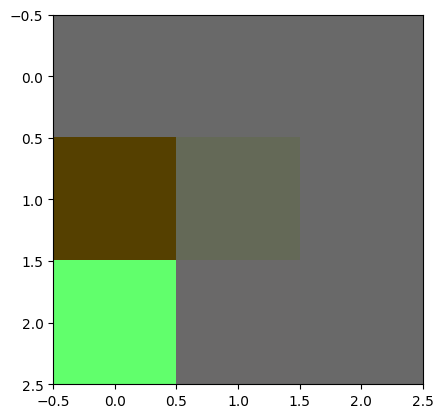

In [8]:
img = np.reshape(sarsa_agent.QTable, (4,9,2,3))
imx = np.reshape(img[3,:,1,:], (3,3,3))
print(imx[0,2], imx[1,2])
plt.imshow((imx-np.min(imx))/(np.max(imx)-np.min(imx)))